In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/Archivos/DS/LifeMiles/datos_entrenamiento_evaluacion.csv")
raw_dataset.head()

,id,nombre_carro,anno_fab,combustible,kms_recorridos,precio,ciudad,visitas,tipo,transmision,motor,asegurado,ciudad_registro,estado_registro,mayor_venta,oficina_registro,metodo_venta,marca,modelo,disponibilidad,comprados,precio_cotizacion,precio_original,calificacion,fecha_venta,certificado,cuota,prima,estado_reserva,garantia
0,1,maruti swift,2015,gasolina,8063,386399,noida,18715,hatchback,manual,lxi opt,True,delhi,delhi,True,dl6c,inperson_sale,maruti,swift,in_stock,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,2,maruti alto 800,2016,gasolina,23104,265499,noida,2676,hatchback,manual,lxi,True,noida,uttar pradesh,True,up16,inperson_sale,maruti,alto 800,in_stock,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,3,hyundai grand i10,2017,gasolina,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,True,agra,uttar pradesh,True,up80,inperson_sale,hyundai,grand i10,in_stock,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,4,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,True,delhi,delhi,True,dl1c,inperson_sale,maruti,swift,in_stock,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,5,hyundai grand i10,2015,gasolina,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,False,new delhi,delhi,True,dl12,inperson_sale,hyundai,grand i10,in_stock,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False


In [ ]:
  raw_dataset.isnull().sum()

id                      0
nombre_carro            0
anno_fab                0
combustible             0
kms_recorridos          0
precio                  0
ciudad                  0
visitas                 0
tipo                   90
transmision           474
motor                   0
asegurado               0
ciudad_registro         8
estado_registro         8
mayor_venta             0
oficina_registro        0
metodo_venta          114
marca                   0
modelo                  0
disponibilidad        542
comprados               0
precio_cotizacion       0
precio_original      2824
calificacion            7
fecha_venta             1
certificado             8
cuota                   0
prima                   0
estado_reserva          0
garantia                0
dtype: int64

In [ ]:
dataset_copy = raw_dataset.copy()

dataset_copy['uso'] = dataset_copy['kms_recorridos'].div(dataset_copy['anno_fab'].values)
dataset_copy.head()

,id,nombre_carro,anno_fab,combustible,kms_recorridos,precio,ciudad,visitas,tipo,transmision,motor,asegurado,ciudad_registro,estado_registro,mayor_venta,oficina_registro,metodo_venta,marca,modelo,disponibilidad,comprados,precio_cotizacion,precio_original,calificacion,fecha_venta,certificado,cuota,prima,estado_reserva,garantia,uso
0,1,maruti swift,2015,gasolina,8063,386399,noida,18715,hatchback,manual,lxi opt,True,delhi,delhi,True,dl6c,inperson_sale,maruti,swift,in_stock,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False,4.001489
1,2,maruti alto 800,2016,gasolina,23104,265499,noida,2676,hatchback,manual,lxi,True,noida,uttar pradesh,True,up16,inperson_sale,maruti,alto 800,in_stock,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False,11.460317
2,3,hyundai grand i10,2017,gasolina,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,True,agra,uttar pradesh,True,up80,inperson_sale,hyundai,grand i10,in_stock,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False,11.602380
3,4,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,True,delhi,delhi,True,dl1c,inperson_sale,maruti,swift,in_stock,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False,19.435668
4,5,hyundai grand i10,2015,gasolina,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,False,new delhi,delhi,True,dl12,inperson_sale,hyundai,grand i10,in_stock,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False,10.975682


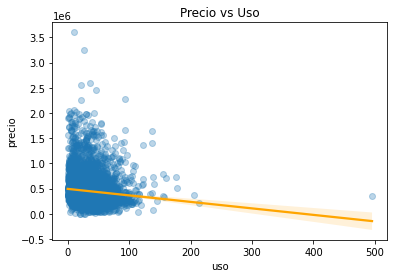

In [ ]:
plt.title("Precio vs Uso")
sns.regplot(x=dataset_copy['uso'], y=dataset_copy['precio'],
            scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})

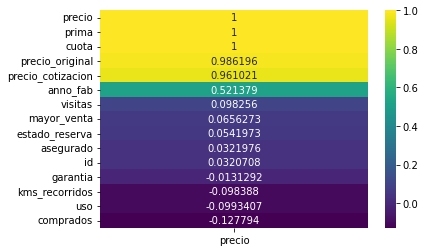

In [ ]:
corr = dataset_copy.corr()

corr.sort_values(by=['precio'], ascending=False, inplace=True)
tmp_df = pd.DataFrame(corr['precio'], index=corr.index)

sns.heatmap(tmp_df, annot=True, fmt="g", cmap='viridis')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
test_ratio = 0.10
train_ratio = 0.80
validation_ratio = 0.10


X_train, X_test, y_train, y_test = train_test_split(X_prepared, car_labels, test_size=1-train_ratio, 
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), 
                                                    random_state=42)

In [ ]:
non_null_data = dataset_copy.dropna()

In [ ]:
reduced_train_data = non_null_data.drop(["id", "nombre_carro", "ciudad",
                                             "visitas", "ciudad_registro",
                                             "estado_registro", "oficina_registro",
                                             "fecha_venta"], axis=1)
reduced_train_data

,anno_fab,combustible,kms_recorridos,precio,tipo,transmision,motor,asegurado,mayor_venta,metodo_venta,marca,modelo,disponibilidad,comprados,precio_cotizacion,precio_original,calificacion,certificado,cuota,prima,estado_reserva,garantia,uso
0,2015,gasolina,8063,386399,hatchback,manual,lxi opt,True,True,inperson_sale,maruti,swift,in_stock,2,397677,404177.0,great,True,8975,57960,False,False,4.001489
1,2016,gasolina,23104,265499,hatchback,manual,lxi,True,True,inperson_sale,maruti,alto 800,in_stock,1,272935,354313.0,great,True,6167,39825,False,False,11.460317
3,2013,diesel,39124,307999,hatchback,manual,vdi,True,True,inperson_sale,maruti,swift,in_stock,1,294262,374326.0,great,True,7154,46200,False,False,19.435668
4,2015,gasolina,22116,361499,hatchback,manual,magna 1.2 vtvt,False,True,inperson_sale,hyundai,grand i10,in_stock,1,360716,367216.0,great,True,8397,54225,False,False,10.975682
7,2012,gasolina,38328,321499,hatchback,manual,asta 1.2,True,True,inperson_sale,hyundai,i20,in_stock,3,319200,410764.0,great,True,7468,48225,False,False,19.049702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6381,2017,diesel,20888,477299,hatchback,manual,sportz1.2 crdi,True,True,inperson_sale,hyundai,grand i10,in_stock,1,460467,562435.0,great,True,11086,71595,True,False,10.355974
6382,2016,diesel,41739,537999,sedan,manual,vdi opt,True,True,inperson_sale,maruti,swift dzire,in_stock,1,548960,673053.0,great,True,12496,80700,True,False,20.703869
6385,2019,gasolina,55048,380799,hatchback,manual,sigma 1.2 k12,True,True,inperson_sale,maruti,ignis,in_stock,1,364200,454738.0,great,True,8845,57120,True,False,27.264983
6386,2018,gasolina,43035,315899,hatchback,manual,1.0 rxt,True,True,inperson_sale,renault,kwid,in_stock,1,283282,358430.0,good,True,7338,47385,True,False,21.325570


In [ ]:
reduced_train_data.drop(['uso'], axis=1, inplace=True)

In [ ]:
# TODO: Pipeline de transformaciones, ordenar pasos, graficar entrenamientos

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
cat_attribs = ["combustible", "tipo", "motor", "metodo_venta", "modelo",
                  "marca", "transmision", "disponibilidad", "calificacion"]

num_attribs = ['anno_fab', 'kms_recorridos', 'comprados',
                           'precio_cotizacion', 'precio_original', 'cuota',
                           'prima']

class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names

  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    return X[self.attribute_names].values

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attribs)),
                         ('imputer', imputer),
                         ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_attribs)),
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_encoder', OneHotEncoder(sparse=False,
                                                       handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
                          ('num_pipeline', num_pipeline),
                          ('cat_pipeline', cat_pipeline)
])

In [ ]:
X_prepared = full_pipeline.fit_transform(car_features)

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg_clf = LinearRegression()
lin_reg_clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lin_reg_pred = lin_reg_clf.predict(X_test)
lin_mse = mean_squared_error(y_test, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

1372625963.2420182

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
predictions = svm_clf.predict(X_test)

In [ ]:
svc_mse = mean_squared_error(y_test, predictions)
svc_rmse = np.sqrt(svc_mse)

svc_rmse

305058.4305201405

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest_reg = RandomForestRegressor(random_state=42)
param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': ['auto', 'sqrt',
                                                             'log2']},
              {'n_estimators': [30, 60, 100], 'max_features': ['auto', 'sqrt',
                                                             'log2']}
              
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
grid_search.best_params_, np.sqrt(-grid_search.best_score_)

({'max_features': 'auto', 'n_estimators': 10}, 15834.33272382685)

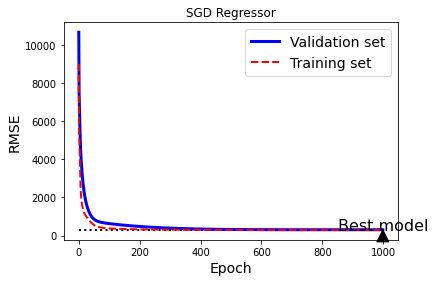

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from copy import deepcopy

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty="l2", learning_rate="adaptive", eta0=0.05, 
                       random_state=42, early_stopping=True)

minimum_test_error = float("inf")

n_epochs = 1000
train_errors, test_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train, y_train)
    y_train_predict = sgd_reg.predict(X_train)
    y_test_predict = sgd_reg.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    test_errors.append(mean_squared_error(y_test, y_test_predict))
    test_error = mean_squared_error(y_test, y_test_predict)
    if test_error < minimum_test_error:
        minimum_test_error = test_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

best_epoch = epoch
best_test_rmse = np.sqrt(test_errors[best_epoch])
plt.annotate('Best model',
             xy=(best_epoch, best_test_rmse),
             xytext=(best_epoch, best_test_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

plt.title('SGD Regressor')
plt.plot([0, n_epochs], [best_test_rmse, best_test_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [ ]:
best_epoch, best_model, best_test_rmse

val_predictions = sgd_reg.predict(X_val)
sgd_val_mse = mean_squared_error(y_val, val_predictions)
sgd_val_rmse = np.sqrt(sgd_val_mse)
sgd_val_rmse, best_test_rmse

# With 0.05 LR - 320
# With 0.01 LR - 
# With 1000 epochs - 654
# With 500 epochs - 915.89

(328.8062548506059, 307.5750557385438)

In [ ]:
final_dataset = pd.read_csv("/content/drive/MyDrive/Archivos/DS/LifeMiles/datos_prueba_evaluacion.csv")
reduced_final_dataset = final_dataset.drop(["id", "nombre_carro", "ciudad",
                                            "visitas", "ciudad_registro",
                                            "estado_registro", "oficina_registro",
                                            "fecha_venta"], axis=1)
reduced_final_dataset["combustible"] = reduced_final_dataset[reduced_final_dataset["combustible"] != "electrico"]
final_dataset.shape, raw_dataset.shape

((1000, 29), (6399, 30))

In [ ]:
X_final_prepared = full_pipeline.transform(reduced_final_dataset)

X_final_prepared.shape, X_prepared.shape

((1000, 653), (3163, 653))

In [ ]:
final_predictions = sgd_reg.predict(X_final_prepared)

In [ ]:
complete_final_dataset = final_dataset.copy()
complete_final_dataset["precio"] = [int(i) for i in final_predictions]
complete_final_dataset.to_csv("/content/drive/MyDrive/Archivos/DS/LifeMiles/datos_finales.csv")